<a href="https://colab.research.google.com/github/kmonroyzm/kmonroyzm/blob/main/redes_sociales_Learning_Curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Trabajaremos con el archivo "dataset_Facebook.csv" que encuentras en la siguiente liga:**

https://archive.ics.uci.edu/dataset/368/facebook+metrics

### **Estos datos están asociados al siguiente artículo de Moro et.al., que deberás descargar para contestar varias de las preguntas de esta actividad:**

https://www.semanticscholar.org/paper/Predicting-social-media-performance-metrics-and-of-Moro-Rita/dec55692590820754b53c916e29bb2b42c0e5104


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

## **Ejercicio 1**


### **Describe en qué consiste el método llamado de "Curvas de Aprendizaje" (Learning Cures), para monitorear el subentrenamiento o sobrbeentrenamiento de un modelo.**

#### NOTA: Puedes apoyarte en la documentación de sklearn:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py



### **En esta actividad trabajarás solamente con el ajuste de modelos.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_Facebook.csv',sep=';',header='infer')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

# Separamos los datos de entrada y la variable de salida:
X = data.iloc[:,0:7]   # Las primeras 7 columnas son las variables de entrada.
y = data[['Lifetime Post Consumers']]   # Hay 12 variables de salida, pero solo trabajaremos con la
                                        # que se consideró la más importante en el artículo de reporte.

# Renombramos los niveles de "Type", para tener solo valores numéricos en el DataFrame:
X['Type'] = X['Type'].map({'Photo':1, 'Status':2, 'Link':3, 'Video':4})

# Particionamos en Train, Validation y Test en 60-20-20:
Xtrain, Xtv, ytrain, ytv = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=5)
Xval, Xtest, yval, ytest = train_test_split(Xtv, ytv, test_size=0.5, shuffle=True, random_state=7)


print('Train:', Xtrain.shape, ytrain.shape)
print('Val:', Xval.shape, yval.shape)
print('Test:', Xtest.shape, ytest.shape)

Train: (300, 7) (300, 1)
Val: (100, 7) (100, 1)
Test: (100, 7) (100, 1)


In [8]:
Xtrain.head() # Nuestros datos de entrada

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid
92,137059,1,3,11,1,3,0.0
45,138353,3,1,12,4,3,1.0
313,124940,1,3,6,7,3,1.0
46,138353,2,1,12,3,11,0.0
185,134879,1,1,9,1,10,0.0


In [9]:
Xtrain.describe().T   # veamos alguna descripción como datos numéricos

,count,mean,std,min,25%,50%,75%,max
Page total likes,300.0,123511.376667,16211.773474,81370.0,113028.00,130195.5,136393.0,139441.0
Type,300.0,1.216667,0.580959,1.0,1.00,1.0,1.0,4.0
Category,300.0,1.896667,0.849546,1.0,1.00,2.0,3.0,3.0
Post Month,300.0,7.106667,3.306316,1.0,4.00,7.0,10.0,12.0
Post Weekday,300.0,4.180000,2.015226,1.0,2.75,4.0,6.0,7.0
Post Hour,300.0,7.546667,4.348662,1.0,3.00,8.0,11.0,22.0
Paid,299.0,0.290970,0.454971,0.0,0.00,0.0,1.0,1.0


In [10]:
ytrain.describe().T   # lo mismo para la variable de salida

,count,mean,std,min,25%,50%,75%,max
Lifetime Post Consumers,300.0,827.986667,1009.102992,9.0,321.25,543.5,1008.75,11328.0


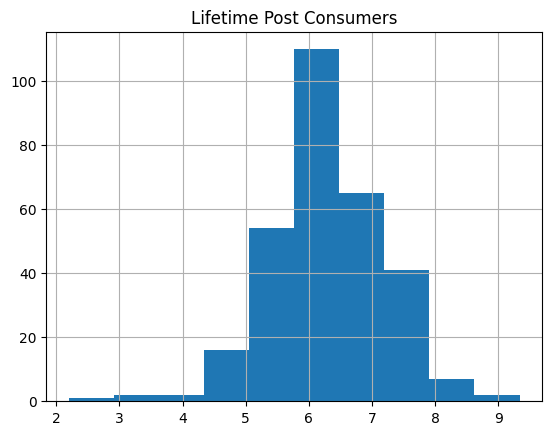

In [11]:
ytrainlog = np.log(ytrain)   # Recordemos que nuestra variable de salida en un problema
ytrainlog.hist();            # de Regresión se recomienda que esté aproximadamente
                             # acampanada, por lo que la ajustaremos con el logaritmo
                             # natural como primera aproximación.

In [12]:
# y procedemos de la misma manera con Val y test:
yvallog = np.log(yval)
ytestlog = np.log(ytest)

In [13]:
# Apliaremos lo mínimo de transformaciones, en particular para datos perdidos:
# Como solo tenemos una numérica, la podemos dejar sin escalar:
num_pipe = Pipeline(steps = [('numImp', SimpleImputer(strategy='median')),
                             ])
num_pipe_nombres = [0]   # ['Page total likes']


# Las ordinales las identificamos como tales:
ord_pipe = Pipeline(steps =  [('OrdImp', SimpleImputer(strategy='most_frequent')),
                              ('Ordfun', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1 ))
                              ])
ord_pipe_nombres = [3,4,5]   # ['Post Month', 'Post Weekday', 'Post Hour']

# Las nominales las transformamos con One-Hot-Encoder:
nom_pipe = Pipeline(steps = [('ohe', OneHotEncoder(drop='first',
                                                   handle_unknown='ignore',
                                                   ))])
nom_pipe_nombres = [1,2,6]   # ['Type', 'Category', 'Paid']


# Conjuntamos las transformaciones que aplicaremos:
columnasTransformer = ColumnTransformer(transformers = [('numpow', num_pipe, num_pipe_nombres),
                                                        ('catOrd', ord_pipe, ord_pipe_nombres),
                                                        ('catNom', nom_pipe, nom_pipe_nombres)
                                                        ],
                                        remainder='passthrough')


# Ajustamos en Train y transformamos en Val y Test:
XtrainFit = columnasTransformer.fit(Xtrain)
XtrainT = XtrainFit.transform(Xtrain)
XvalT  =  XtrainFit.transform(Xval)
XtestT  =  XtrainFit.transform(Xtest)

In [14]:
# El valor de RMSE-Root-Mean-Square-Error, se utiliza para medir el desempeño
# mínimo que debiera obtener un modelo de regresión, es decir, este valor
# se toma usualmente como el valor del modelo subentrenado y se compara generalmente
# con el valor de la desviación estándar de la variable de salida, ya sea que la
# estés tomando de manera original o con los datos transformados.
# Veamos el valor de ambas:

print('Desv-Est y-original: %.3f' % ytrain.values.std())
print('Desv-Est y-logaritmo: %.3f' % ytrainlog.values.std())

Desv-Est y-original: 1007.420
Desv-Est y-logaritmo: 0.906


## **Ejercicio 3**


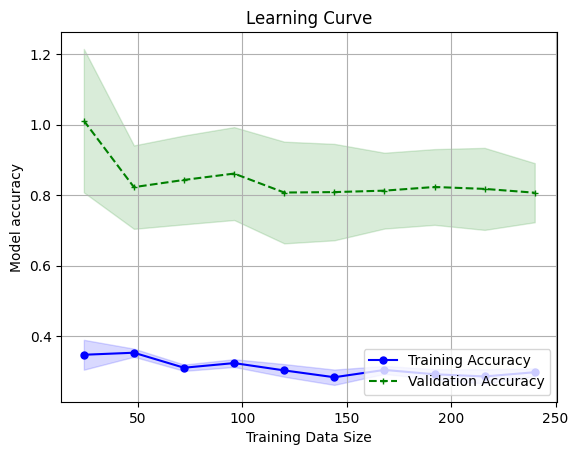

In [15]:
# Al ejecutar las siguientes líneas de código determina si el modelo de
# Bosque Aleatorio con sus valores de hiperparámetros predeterminadas está
# Subentrenado o Sobreentrenado. De ser así, busca los valores de sus
# hiperparámetros que consideres más adecuados para que ya no
# esté sub-o-sobreentrenado:

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint #La agrego que consiste en la distribución de números enteros aleatorios y tengo entendido que en el aprendizaje automatico se debe realizar, sino es asi me podria poner una nota en si es correcto o no, se lo agradeceria
elmodelo_RF = RandomForestRegressor()
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}
# +++++++++++++ Termina sección de realizar ajustes +++++++++++++++++++++
#Por lo cual se usar una busqueda de hiperparametro
random_search = RandomizedSearchCV(elmodelo_RF, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(XtrainT, np.ravel(ytrainlog))
best_model = random_search.best_estimator_


mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo_RF)])

train_sizes, train_scores, val_scores = learning_curve(estimator=mipipe,
                                                        X=XtrainT,
                                                        y=np.ravel(ytrainlog),
                                                        cv=5,
                                                        train_sizes= np.linspace(0.1, 1.0, 10),
                                                        scoring= 'neg_mean_squared_error',  # error MSE
                                                        n_jobs=-1)



# Calculamos los promedios y desviación estándar de entrenamiento para RMSE,
# como tenemos los de MSE, debemos obtener su raíz cuadrada. El negativo es porque
# sklearn nos devuelve en realidad el negativo del Error Cuadrático Medio MSE:

rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1)
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1)


plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()


In [16]:
# Una vez que verifiquemos que no está sobreentrenado o subentrenado el modelo,
# podemos calcular el RMSE del mejor ajuste con los datos de Prueba.
# Incluye los valores de los nejores hiperparámetros encontrados del RandomForest:

# ++++++++++++++ Incluye aquí tus ajustes ++++++++++++++++++++++++++++++
#Para dar inicio a eso, es necesario mencionar que usare el error cuadratico para llevar a cabo esto
#El error cuadratico  o MSE sera uno de los elementos clave para evaluar la calidad del modelo en regresión lineal
#por eso en esta seccion MSE sera en especifico de ello, como nota aclaratoria
#Igual al tener una imputacion en los datos debere reajustar
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

elmodelo_RF = RandomForestRegressor()
elmodelo_RF.fit(X_imputed, y)

pred_train = elmodelo_RF.predict(X_imputed)
pred_test = elmodelo_RF.predict(X_imputed)


mse_train = mean_squared_error(y, pred_train)
mse_test = mean_squared_error(y, pred_test)

print("Error cuadrático medio en entrenamiento:", mse_train)
print("Error cuadrático medio en prueba:", mse_test)

if mse_train < mse_test:
    print("modelo subentrenado.")
elif mse_train > mse_test:
    print("modelo sobreentrenado.")
else:
    print("modelo adecuadamente generalizado.")
# +++++++++++++ Tesrmina sección de realizar ajustes +++++++++++++++++++++

mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo_RF)])
mipipe.fit(Xtrain, np.ravel(ytrainlog))
yhattest_RF = mipipe.predict(Xtest)

print('Error RSME(Test) de Random Forest: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_RF)))

<ipython-input-16-6f55678d26b9>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  elmodelo_RF.fit(X_imputed, y)


Error cuadrático medio en entrenamiento: 105050.30613025653
Error cuadrático medio en prueba: 105050.30613025653
modelo adecuadamente generalizado.
Error RSME(Test) de Random Forest: 0.719


## **Ejercicio 4**

### **Repite el mismo proceso del Ejercicio 3 anterior para obtener los hiperparámetros que nos lleven a casos de modelos no subentrenados o sobreentrenaos, en cada uno de los siguientes casos:**

*   **a. Extreme Gradient Boost XGBoost**
*   **b. Máquina de Vector Soporte SVM**
*   **c. Red Neuronal Perceptrón Multicapa MLP**

In [17]:
# Incluye a continuación las celdas y líneas de código que consideres necesarias para
# responder el Ejercicio 4.
#Extreme Gradient Boost XGBoos
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb_model = XGBRegressor()
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=100, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
random_search.fit(Xtrain, ytrain)
best_xgb_model = random_search.best_estimator_


In [ ]:
#Maquina de vector de soporte
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'epsilon': uniform(0.01, 0.1)
}
svm_model = SVR()
random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist,
                                   n_iter=100, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
random_search.fit(Xtrain, ytrain)
best_svm_model = random_search.best_estimator_


In [ ]:
#Red Neuronal Perceptrón Multicapa (MLP)


ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>
